# Snapshot Ensembles experiments

Let's build an ensemble of models for MNIST classification problem. For building an ensemble we use concept 'Train 1, get M for free', described in the [paper](https://arxiv.org/abs/1704.00109)

![title](http://ipic.su/img/img7/fs/1.1507631798.png)

In standard practice the model converges to a minimum at the end of training (left figure).

In snapshot ensemble concept the model undergoes several learning rate annealing cycles, converging to and escaping from multiple local minima. We take a snapshot at each minimum for test-time ensembling (right figure).

In [1]:
%matplotlib inline
%env CUDA_VISIBLE_DEVICES = 1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import sys

import numpy as np
import os
import blosc

import tensorflow as tf
import matplotlib.pyplot as plt

import os
import blosc

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

sys.path.append("..//..")

from dataset import DatasetIndex, Dataset
from dataset import Batch, action, model, inbatch_parallel
from ensemble_resnet_batch import MnistBatch
from ensemble_resnet_batch import draw_stats

Load MNIST data

In [3]:
src = './../task_03//'

with open(os.path.join(src, 'mnist_pics.blk'), 'rb') as file:
    full_imgs = blosc.unpack_array(file.read())
    
with open(os.path.join(src, 'mnist_labels.blk'), 'rb') as file:
    full_labs = blosc.unpack_array(file.read())
    
src = (np.reshape(full_imgs, (65000, 28, 28)), full_labs)

# LEN_MNIST = 65000
# indy = DatasetIndex(np.arange(LEN_MNIST))

# mnistset = Dataset(indy, batch_class=MnistBatch)
# mnistset.cv_split([0.9, 0.1])

ix = DatasetIndex(range(58500))
train_dataset = Dataset(ix, MnistBatch)

ix_test = DatasetIndex(range(65000 - 58500))
test_dataset = Dataset(ix_test, MnistBatch)

We train one model for 2000 iterations with cyclic learning rate:

\begin{align}
\alpha(t) = \frac{\alpha_0}{2} \left( \cos \left( \frac{\pi mod(t-1, [T/M])}{[T/M]} \right) + 1 \right) \in [\alpha_0, 0]
\end{align}

And save 4 snapshot models at each minimum of learning rate

In [59]:
alpha = 0.1
period = 400
n_iterations = 1601

In [60]:
config = {'resnet':{'period':period, 'n_iterations':n_iterations, 'alpha':alpha}}

In [61]:
stats = []
loss_history = []
train_accs = []
train_loss_history = []

In [62]:
# pipeline for train
ppl = (train_dataset.pipeline(config=config).
       train_res(train_loss_history, train_accs, src[0][:58500], full_labs[:58500]))

# pipeline for test
ppl_test = (test_dataset.pipeline(config=config).import_model('resnet', ppl).
            update_stats(stats, loss_history, src[0][58500:], src[1][58500:]))

In [63]:
for i in tqdm(range(n_iterations)):
    ppl.next_batch(100, n_epochs=None, shuffle=2)
    ppl_test.next_batch(100, n_epochs=None, shuffle=2)

Accuracy on train

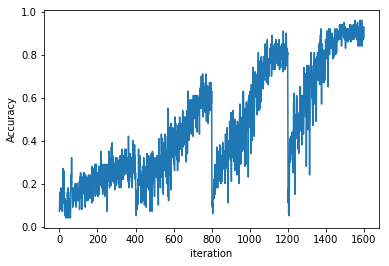

In [67]:
draw_stats(stats, '', 'Accuracy')

Loss on train

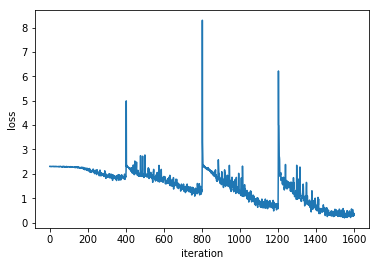

In [66]:
draw_stats(loss_history, '', 'loss')

Load saved models (the last 3 ones) and take average of the softmax outputs of every model to get an ensemble result:

In [68]:
ensemble_stats = []
ensemble_loss_history = []

# pipeline for ensemble test
ppl_ens_test = (test_dataset.pipeline(config).
            update_stats_ensemble(config, ensemble_stats, ensemble_loss_history, src[0][58500:], src[1][58500:]))

In [69]:
for i in tqdm(range(65)):
    ppl_ens_test.next_batch(100, n_epochs=None)

currently loading trained+400/model-400.meta
INFO:tensorflow:Restoring parameters from trained+400/model-400
currently loading trained+800/model-800.meta
INFO:tensorflow:Restoring parameters from trained+800/model-800
currently loading trained+1200/model-1200.meta
INFO:tensorflow:Restoring parameters from trained+1200/model-1200
currently loading trained+1600/model-1600.meta
INFO:tensorflow:Restoring parameters from trained+1600/model-1600



Unfortunately we see that ensemble result do not seem to be better than the final model:

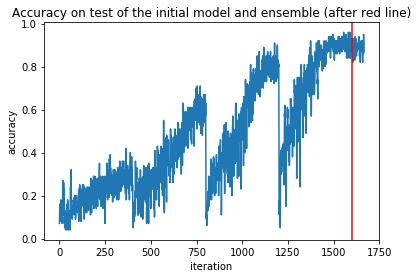

In [77]:
plt.title('Accuracy on test of the initial model and ensemble (after red line)')
plt.plot(stats + ensemble_stats)
plt.axvline(x=1601, c='r')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.show()

It is pretty clear looking on the loss dynamic:

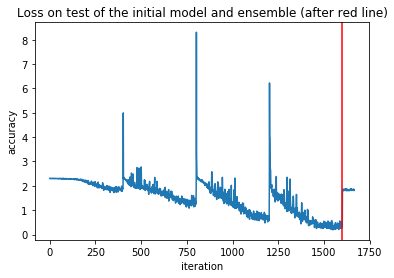

In [78]:
plt.title('Loss on test of the initial model and ensemble (after red line)')
plt.plot(loss_history + ensemble_loss_history)
plt.axvline(x=1601, c='r')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.show()

Earlier models were worse than the final one, that is why have just spoiled the last model's results and averaging of several local minima haven't done any good. 

The main problem is that suggested learning rate schedule may not be the best option in some cases and one will spend 10 times more time on fine tunning period, alpha (it is very sensitive to model's layout) comparing to using standard learning rate schedule.

In [85]:
print('Ensemble accuracy: ', np.mean(ensemble_stats))
print('Last model accuracy: ', np.mean(stats[-50:]))

Ensemble accuracy:  0.886
Last model accuracy:  0.9054


## Summary

We did get en ensemble of multiple neural networks at the training time of single model. But it took us 4 times more time to train this model to get 3 adequate snaphots models (comparing to traditional lr schedule):

## Comparison

Results of the same model with standard dacaying learning rate:

In [4]:
st_stats = []
st_loss_history = []
st_train_accs = []
st_train_loss_history = []
st_config = {'standard_resnet':{}}

In [5]:
st_ppl = (train_dataset.pipeline(config=st_config).
       train_standard_resnet(st_train_loss_history, st_train_accs, src[0][:58500], full_labs[:58500]))

st_ppl_test = (test_dataset.pipeline(config=st_config).import_model('standard_resnet', st_ppl).
            update_stats_standard_resnet(st_stats, st_loss_history, src[0][58500:], src[1][58500:]))

In [6]:
for i in tqdm(range(400)):
    st_ppl.next_batch(100, n_epochs=None, shuffle=2)
    st_ppl_test.next_batch(100, n_epochs=None, shuffle=2)

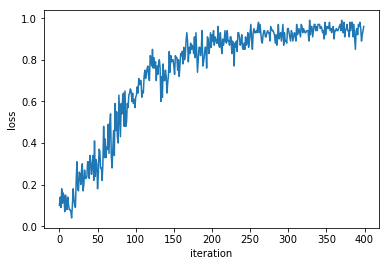

In [8]:
draw_stats(st_stats, '', 'loss')

In [11]:
print('Model accuracy with standard learning rate: ', np.mean(st_stats[-50:]))

Model accuracy with standard learning rate:  0.9454
